In [1]:
import numpy as np
from model import *
import tensorflow as tf
import setGPU
#strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

imgs = np.load('../dataset/cv/train/x/imgs_grayscale.npz')['arr_0']
labels = np.load('../dataset/cv/train/y/labels.npy')

setGPU: Setting GPU to: 0


In [3]:
characters = set(char for label in labels for char in label)

In [4]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [5]:
imgs = np.transpose(imgs, (0, 2, 1, 3))
'''
max_len = max([len(label) for label in labels])
encoded_labels = []
for label in labels:
    if label:
        tmp = np.array([char_to_num(char) for char in label])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
    else:
        tmp = np.array([char_to_num('#')])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
'''

encoded_labels = np.load('../dataset/cv/train/y/encoded_labels.npy')

In [6]:
#Si inserisce alla fine di ogni array label la lunghezza reale della parola
t_dist_dim = int(128)          # Questo valore indica quanti step temporali ci sono: nelle ultime feature map ci sono 128/4
                                 # step temporali perché 128 è la larghezza massima tra le immagini in ingresso e 4 è il fattore
                                 # di riduzione dovuto ai MaxPooling (ci sono 2 livelli di MaxPooling che dimezzano le dimensioni)
enc2 = []
for i in range(encoded_labels.shape[0]):
    if len(labels[i]) == 0:
        enc2.append(np.append(encoded_labels[i], [1, t_dist_dim]))
    else:
        enc2.append(np.append(encoded_labels[i], [len(labels[i]), t_dist_dim]))
enc2 = np.array(enc2)

In [7]:
#with strategy.scope():
net = build_and_compile_model_v8(input_shape=(128, 128, 1), len_characters=len(characters), opt="Adam")

In [8]:
net.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 64, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 64, 128)      73856     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 64, 128)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 32, 128)     

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Early_Stopping_Patience = 10 
Min_Delta = 0.0001
# Model Check Point
Check_Point = ModelCheckpoint( 'weights/CRNN_v8.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0002)

In [10]:
batch_size = 32
x_train = imgs
y_train = enc2

In [ ]:
history = net.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[Check_Point, reduce_lr], batch_size=batch_size, shuffle=True)

Epoch 1/100
906/906 [==============================] - ETA: 0s - loss: 25.7289
Epoch 00001: val_loss improved from inf to 39.70912, saving model to weights/CRNN_v8.h5
906/906 [==============================] - 147s 162ms/step - loss: 25.7289 - val_loss: 39.7091
Epoch 2/100
906/906 [==============================] - ETA: 0s - loss: 23.2942
Epoch 00002: val_loss improved from 39.70912 to 23.49923, saving model to weights/CRNN_v8.h5
906/906 [==============================] - 146s 162ms/step - loss: 23.2942 - val_loss: 23.4992
Epoch 3/100
906/906 [==============================] - ETA: 0s - loss: 22.6490
Epoch 00003: val_loss improved from 23.49923 to 23.00181, saving model to weights/CRNN_v8.h5
906/906 [==============================] - 146s 161ms/step - loss: 22.6490 - val_loss: 23.0018
Epoch 4/100
906/906 [==============================] - ETA: 0s - loss: 22.2006
Epoch 00004: val_loss improved from 23.00181 to 22.97358, saving model to weights/CRNN_v8.h5
906/906 [=======================

In [ ]:
np.save('history/my_history_v8.npy',history.history)

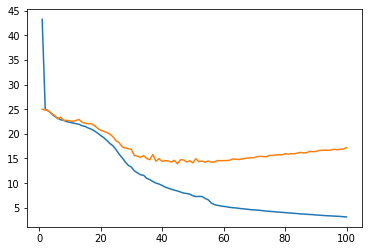

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(1, 101), history.history['loss'])
plt.plot(range(1, 101), history.history['val_loss'])

In [11]:
lbl_to_char_dict = {0: '0',
                        1: '1',
                        2: '2',
                        3: '3',
                        4: '4',
                        5: '5',
                        6: '6',
                        7: '7',
                        8: '8',
                        9: '9'}

In [12]:
def decode_ctc(args):
    """returns a list of decoded ctc losses"""

    y_pred, input_length = args

    ctc_decoded = tf.keras.backend.ctc_decode(
        y_pred, input_length, greedy=True)

    return ctc_decoded

In [20]:
net.predict(np.expand_dims(imgs[0], axis=0)).squeeze().shape

(128, 257)

In [22]:
pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(imgs[0], axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [28]:
pred_labels

array([[35, 49, 50, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])